# **Implementing YOLO v1 in PyTorch**

<div>
     <center><img src="./img/predictions.jpg" width="750"/> </center>
</div>

## **1. What is YOLO?**

<div>
     <center><img src="./img/yolo.png" width="400"/> </center>
</div>

Developed in 2015 by Redmon et. al., YOLO (You Only Look Once) is a deep learning architecture which greatly improved the efficiency of image detection networks. The goal is simply: to detect objects appearing in an image, with their corresponding bounding boxes (see above image). Previous networks would train separately for category detection (dog, bicyle, laptop, e.g.) and bounding box detection (where an object appears in an image), going back and forth between the two to refine predictions. Redmon et. al. proposed a novel method in which bounding boxes and categories were predicted together in one pass through a single model, hence the model's name *You Only Look Once.*

#### **Why is it an important problem? (SAM)**


#### **Main contributions of YOLO (MATT)**

YOLO's main contribution to the study of object recognition is its speed while maintaining correctness. As touched on above by calculating both the bounding boxes and the categorization in a single pass, YOLO completely outperformed the then current the state-of-the-art (Fast R-CNN). YOLO's original code is implemented entirely in C which also contributed to the immense speed up. Additionally compared to Fast R-CNN, YOLO made fewer background mistakes and was able to augment Fast R-CNN to produce an improved mAP score. Overall YOLO was the first object detection software that could run in real time with mostly correct predictions. Running at 45 frames per second with a corrisponding mAP score of 63.4, YOLO exceeds the mAP of other real time detectors by over 2 times; and compared to non-real-time detects only loses ~10 mAP.

## **2. YOLO v1 at a High Level**


an intro

#### **Data and Importing (SAM)**

For our training data input, we resize each image to 112px by 112px and apply a greyscale filter. We take the pixel values in a 112x112 matrix and scale the values between -1 and 1. We take all of these scaled image matrices and feed them into our dataloader.
<div>
     <center><img src="./img/imageinput.png" width="750"/> </center>
</div>

#### **Architecture (MATT)**

<div>
     <center><img src="./img/arch.png" width="750"/> </center>
</div>

YOLO's architecture consists of 24 convolutional layers followed by 2 fullin connected layers detailed above. The 1x1 convolutional layers are in place to reduce the feature space from preceding layers. This may be confusing at first as a 1x1 convolution with a stride of 1 just copies the image however; roughly speaking, different features of the input can be "learned" by different kernels of the 1x1 layer thus reducing the feature space. 

Object detection is a hard task, and at this point had not been achieved in real time. In order to simplify the task YOLO was first pre-trained to recognize images. For pre-training only the first 20 layers were trained followed by an average-pooling and fully connected layer --- these additional layer were truncated in the actual YOLO model.Using the ImageNet 2012 data the model was trained to recognize images from one of 20 catagories. After a week of training, the model achieved a top-5 accuracy of 88\% (meaning each of the network contained the correct answer in the top 5 catagories it predicted 88\% of the time).

The intuitive reasoning for YOLO's pre-training can be explained with a simple example. Say I gave you an image and asked you to find every fish in the image and draw a box around it (this is essentially the YOLO task). You could probably do it --- but say you didn't know what a fish actually looked like, the task becomes significantly harder. The same is true with YOLO, by teaching it how to recognize images in a well defined dataset of ImageNet it will help make predicting bounding boxes possible.

Up until the last layer, YOLO is just a standard CNN. In each layer of the CNN, it learns something about the pixel and the surrounding pixels in order to make its final prediction. To prevent overfitting a dropout layer with p = 0.5 is added after the first connected layer. Additionally YOLO randomly augments the data by changing the size, exposure and saturation to help with overfitting. To enforce non-linearity the leaky rectified linear unit (leaky ReLU) activation function is used with the parameter 0.1 following each layer besides the final layer. The final layer is special and uses a linear activation.

The final prediction of YOLO is where the novelty of the model comes from. The last dense layer is reshaped into a SxSxC+(B*5) tensor where S is the chosen grid size, C is the number of catagories and B is number of boxes predicted in each grid square. YOLO uses a grid size of 7x7 and 2 boxes per square to predict across 20 catagories resulting in an output of size 7x7x30. An example is seen in the image below. This approach allows both the catagory and the bounding boxes to be predicted simultaniously for fast unified detection. Working with this output is less straightforward then something like a series of probability weights or a single value; however YOLO provides a unique loss function to handle this. 



<div>
     <center><img src="./img/grid.png" width="750"/> </center>
</div>

#### **Loss (SAM)**

YOLO v1 implements a custom loss function, described in their paper in the following equation:

<div>
     <center><img src="./img/lossfunction.png" width="750"/> </center>
</div>

This may look overwhelming at first, but it's not overly complicated. The loss function takes the SSE across the predicted $(x,y)$ box midpoint, $(h,w)$ box dimensions, and the set of $c_i$ category probabilities. Some other important symbols:

$𝟙_{i}^{\textrm{obj}}$ indicates whether an object appears in cell $i$

$𝟙_{ij}^{\textrm{obj}}$ indicates whether the $j^{\textrm{th}}$ bounding box predictor in cell $i$ is "responsible" for that prediction (highest intersection over union, or IOU)

$\lambda_{\textrm{coord}}$ is a learning parameter set to 5

$\lambda_{\textrm{noobj}}$ is a learning parameter set to 0.5

To implement this loss function, we first have to define a custom loss function in torch. We create a new `torch.nn.Module` for our custom loss, which we will call `YOLOLoss`:

We then define a `forward` function for computing the loss. The full loss function, including the extensive `forward` function, can be found in `loss.py`. We borrow most of this code from https://github.com/aladdinpersson, as while it is not a conceptually difficult loss function, the actual code implementation with torch functions becomes a bit unweildy.

#### **Evaluation (MATT)**

text

## **3. Our Simplified Implementation**

an intro (MATT)

what we did differently
- from 20 image categories to 5 shape categories
    - changing loss function
- removed bounding_box_2 in loss
- simplified network
    - removed some layers
    - reduced number of kernels per layer (20 vs 200)
- overall compressing output

#### **Data and Generation (MATT)**

text



In [10]:
# IMPORTS
%load_ext autoreload
%autoreload 2
import torch
import os
import random
from IPython.display import HTML, Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
### CONSTANTS

DATA_DIR = "DEMO"
TRAIN_SIZE = 100
TEST_SIZE = 10
PRETRAINED_PARAMS = "models/demo_pretrain.pt"
YOLO_PARAMS = "models/demo_yolo.pt"
CATAGORIES = ['O', 'Pent', 'Square', 'Star', 'X']


In [3]:
# DATA GENERATION
from generate_data import generate_data

generate_data(DATA_DIR, TRAIN_SIZE, TEST_SIZE)


FileExistsError: [Errno 17] File exists: 'DEMO'

In [4]:
### CODE TO DISPLAY GENERATED IMAGES

num = random.randint(0, TRAIN_SIZE)
image_paths = [os.path.join(DATA_DIR, "train", x, str(num) + ".png") for x in os.listdir(os.path.join(DATA_DIR, "train"))]

images_html = ''.join(f'<img src="{path}" style="width: 18%; margin: 10px; float: left;" />' for path in image_paths)

html_content = f'<div style="width: 100%;">{images_html}</div>'

HTML(html_content)

In [5]:
### CODE TO DISPLAY GROUND TRUTH DATA ASSOCIATED WITH THE IMAGES

def display_file_head(file_path, num_lines=19):
    with open(file_path, 'r') as file:
        for _ in range(num_lines):
            line = file.readline()
            if not line:
                break
            print(line.strip())

# Example usage
file_path = os.path.join(DATA_DIR, "data.json")
display_file_head(file_path)

[
{
"label": "X",
"filename": "DEMO/train/X/0.png",
"partition": "train",
"box": "1,0.21625,0.68125,0.1925,0.1925"
},
{
"label": "X",
"filename": "DEMO/train/X/1.png",
"partition": "train",
"box": "1,0.81,0.195,0.345,0.345"
},
{
"label": "X",
"filename": "DEMO/train/X/2.png",
"partition": "train",
"box": "1,0.46375,0.18875,0.1725,0.1725"
},


#### **Architecture (MATT)**

text

In [13]:
### creating the pretraining model
from specs import pretrain_specs
from model import build_net

print("Pretrain Layers:")
pretrain_arch = build_net(pretrain_specs)
print(pretrain_arch)

Pretrain Layers:
Sequential(
  (conv0): ConvLayer()
  (relu1): ReLU()
  (conv2): ConvLayer()
  (relu3): ReLU()
  (conv4): ConvLayer()
  (relu5): ReLU()
  (conv6): ConvLayer()
  (relu7): ReLU()
  (pool8): MaxPool()
  (conv9): ConvLayer()
  (relu10): ReLU()
  (conv11): ConvLayer()
  (relu12): ReLU()
  (pool13): MaxPool()
  (conv14): ConvLayer()
  (relu15): ReLU()
  (conv16): ConvLayer()
  (relu17): ReLU()
  (pool18): MaxPool()
  (flatten19): Flatten()
  (dense20): Dense()
  (relu21): ReLU()
  (dense22): Dense()
)


In [ ]:
### training the pretrained model
from train import pretrain

pretrain(os.path.join(DATA_DIR, "data.json"), PRETRAINED_PARAMS, None)


In [12]:
### Build YOLO model with pretrained parameters
from specs import pretrain_specs, additional_yolo_specs
from model import build_yolo_net

print("YOLO Layers:")
yolo_arch = build_yolo_net(pretrain_specs, additional_yolo_specs, PRETRAINED_PARAMS)
print(yolo_arch)

YOLO Layers:
Sequential(
  (0): ConvLayer()
  (1): ReLU()
  (2): ConvLayer()
  (3): ReLU()
  (4): ConvLayer()
  (5): ReLU()
  (6): ConvLayer()
  (7): ReLU()
  (8): MaxPool()
  (9): ConvLayer()
  (10): ReLU()
  (11): ConvLayer()
  (12): ReLU()
  (13): MaxPool()
  (14): ConvLayer()
  (15): ReLU()
  (16): ConvLayer()
  (17): ReLU()
  (18): MaxPool()
  (19): ConvLayer()
  (20): ReLU()
  (21): ConvLayer()
  (22): ReLU()
  (23): ConvLayer()
  (24): ReLU()
  (25): ConvLayer()
  (26): ReLU()
  (27): Flatten()
  (28): Dense()
  (29): ReLU()
  (30): Dense()
)


In [ ]:
from train import train

train(os.path.join(DATA_DIR, "data.json"), YOLO_PARAMS, None)

In [14]:
### Get trained YOLO model

yolo_model = yolo_arch
yolo_model.load_state_dict(torch.load("models/yolo.pt"))


<All keys matched successfully>

Compute Time: 0.04588007926940918
Prediction: Star


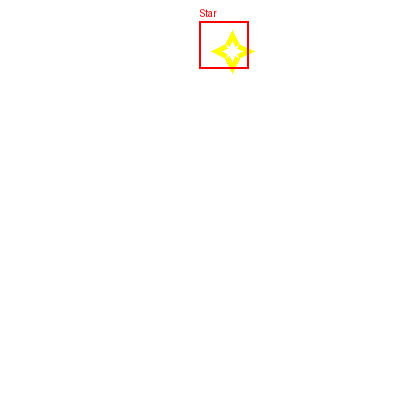

In [91]:
### Predict

from boxey import id

IMAGE_TO_PREDICT = f'{CATAGORIES[random.randint(0,4)]}/{random.randint(0,9)}.png'

# IMAGE_TO_PREDICT = "O/4.png"

predicted = id(os.path.join(DATA_DIR, "test"), IMAGE_TO_PREDICT, yolo_model, CATAGORIES, jupyter=True)

display(predicted)

#### **Loss (SAM)**

text


In [ ]:
#TODO

#### **Evaluation (MATT)**

text

In [ ]:
#TODO

In [ ]:
import torch
import torch.nn

class YOLOLoss(torch.nn.Module):
    """
    Computes loss function according to YOLO v1.

    """
    def __init__(self, S = 7, B = 2, C = 20, l_coord = 5, l_noobj = 0.5):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        self.l_coord = l_coord
        self.l_noobj = l_noobj
        self.mse = torch.nn.MSELoss(reduction="sum") # SSE instead of MSE